Import libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
data = pd.read_csv('/content/bank-additional-full.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#Part 1: EDA

In [ ]:
print(len(data.columns))

21


In [ ]:
print(len(data))

41188


So, our dataset has 21 features and 41188 records.

In [ ]:
print(data.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Our dataset has no null values.

In [ ]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Let's visualize subscribed status to see the proportion between its values.

Text(0.5, 1.0, 'Target')

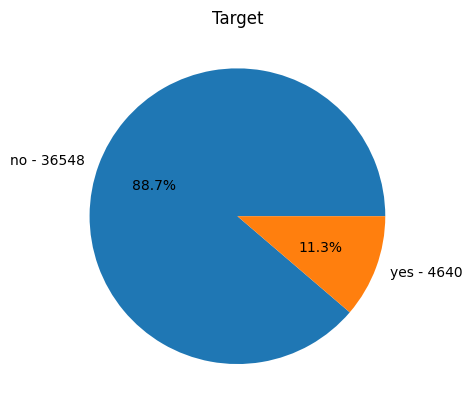

In [ ]:
vc = data['y'].value_counts()
labels = list(map(lambda item: item[0] + ' - ' + str(item[1]), vc.items()))
plt.pie(vc, labels=labels, autopct='%1.1f%%')
plt.title('Target')

We can extract numeric and categorical features separately.

In [ ]:
numeric_features = data.select_dtypes('number').columns
categorical_features = data.select_dtypes(np.object).columns

/tmp/ipykernel_5042/259959596.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = data.select_dtypes(np.object).columns


Let's visualize distribution of numeric features.

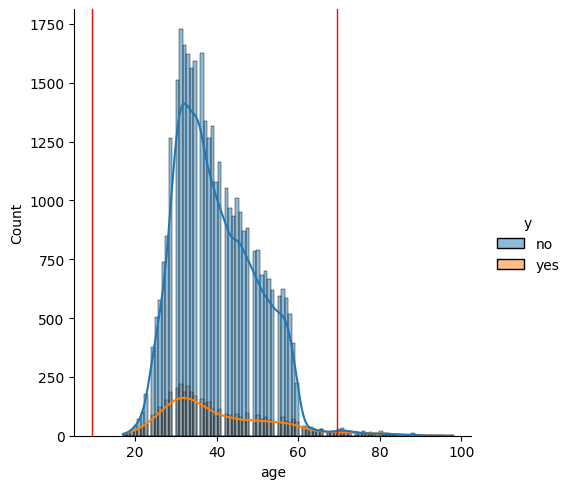

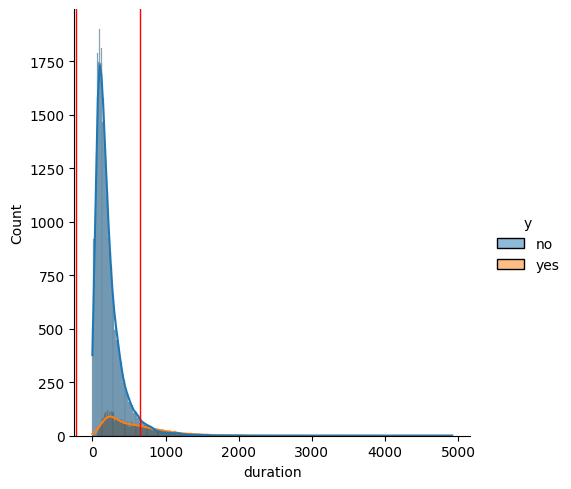

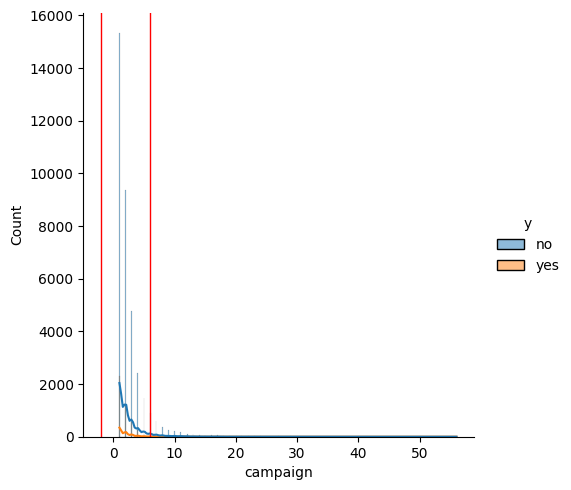

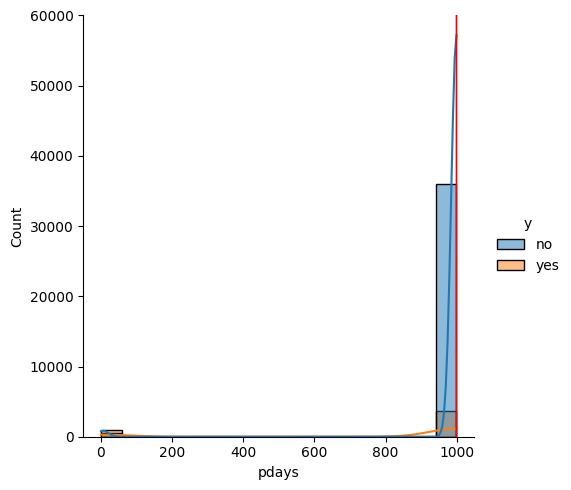

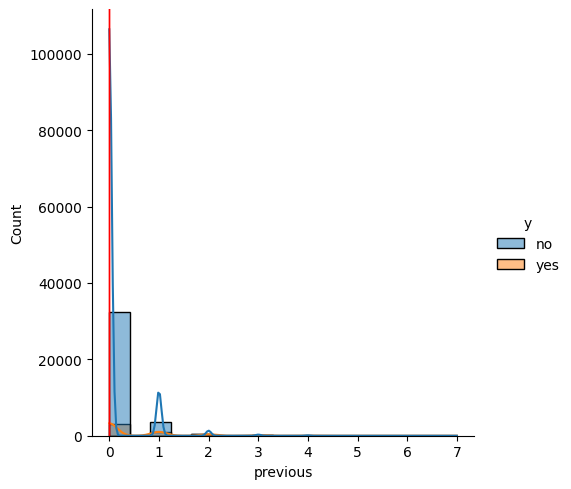

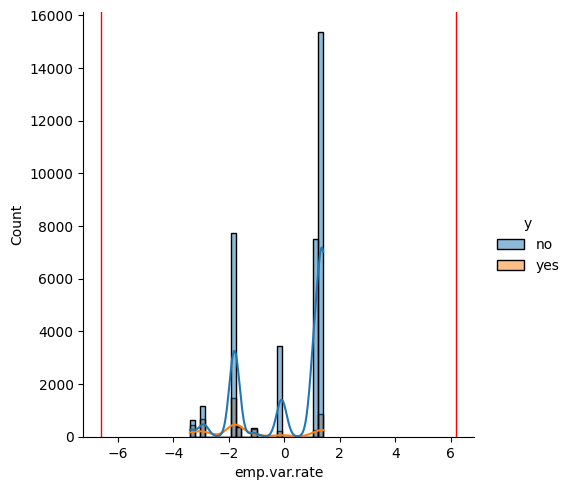

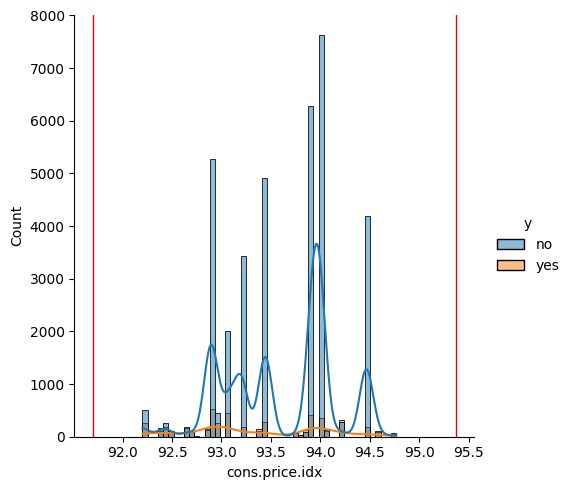

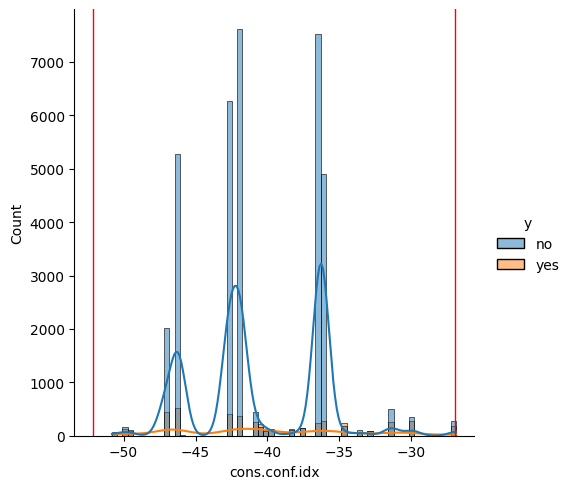

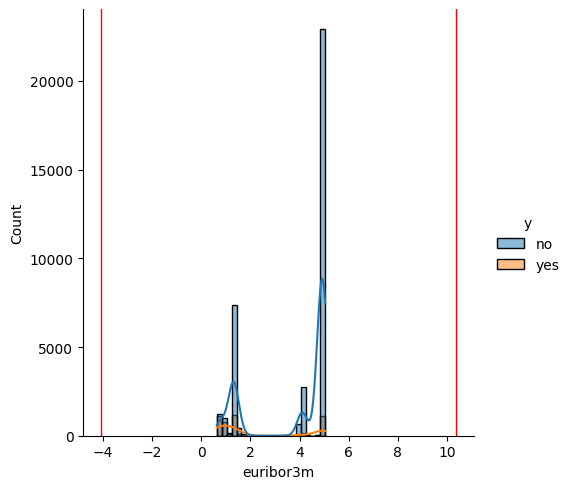

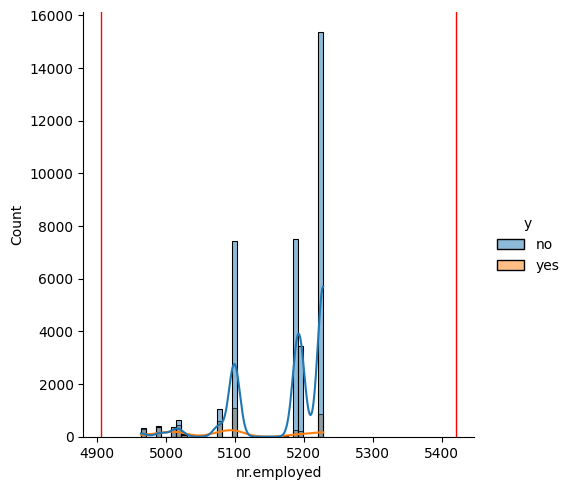

In [ ]:
for col_name in numeric_features:
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1
    #limits:
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    #create histogram
    sns.displot(data, x=col_name, hue="y", kde=True)
    plt.axvline(upper_limit, linewidth=1 , color = 'red')
    plt.axvline(lower_limit, linewidth=1 , color = 'red')
    plt.show()

As we see, `pdays` has value 999 in most cases (999 means client was not previously contacted) so this feature might be not representative for now.

Let's visualize categorical data.

Text(0.5, 0, 'job')

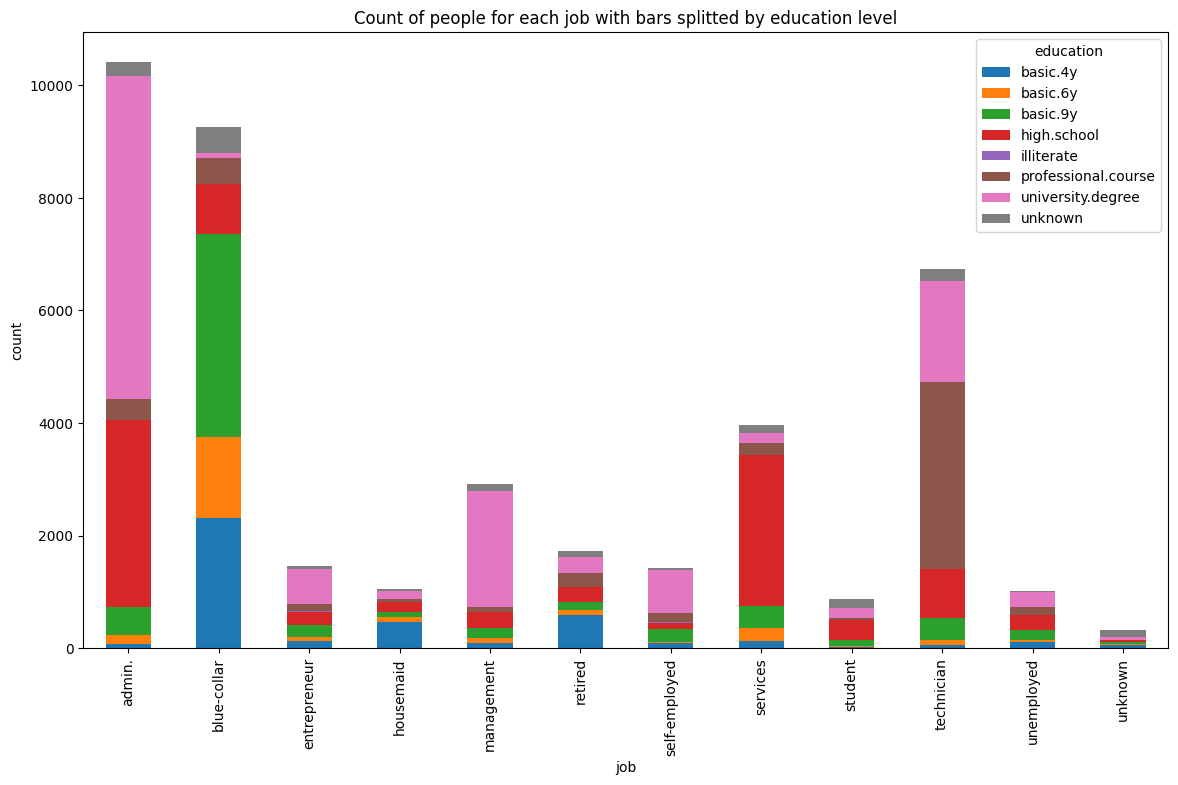

In [ ]:
df_pivot = pd.pivot_table(data,columns='education', index='job', aggfunc='count',values='age')
df_pivot.plot(kind='bar', stacked=True, figsize=(14,8))
plt.title('Count of people for each job with bars splitted by education level')
plt.ylabel('count')
plt.xlabel('job')

We can say that people with jobs 'admin', 'entrepreneur', 'management' and 'self-employed' are more likely to have university degree.

In [ ]:
import math

# function that helps to arrange plots
def make_plots_grid(data, xs, cols, figsize, drawer):
  rows = math.ceil(len(xs) / cols)
  f, axis = plt.subplots(rows, cols, figsize=figsize)

  for index in range(0, len(xs)):
    drawer(x=xs[index], data=data, ax=axis[int(index / cols), index % cols])

In [ ]:
# function for building two-level pie charts
def make_two_level_pie_chart(x, data, ax):
    cols = data[x].value_counts()
    counts = cols.values.tolist()
    types = cols.axes[0].tolist()

    outer_pie_values = []
    outer_pie_labels = []

    for t in types:
        size = len(data[data[x] == t].index)
        subscribed_count = len(data[(data[x] == t) & (data['y'] == 'yes')].index)
        refused_count = size - subscribed_count

        outer_pie_values.append(subscribed_count)
        outer_pie_values.append(refused_count)

        outer_pie_labels.append(str(subscribed_count) + ' - ' + str(round(subscribed_count * 100 / size, 2)) + '%')
        outer_pie_labels.append(str(refused_count) + ' - ' + str(round(refused_count * 100 / size, 2)) + '%')

    ax.set_title(x)

    outer_patches, _ = ax.pie(
        outer_pie_values,
        radius = 4.5,
        labels=outer_pie_labels,
        colors=['#B7D2B2','#E5E9C8'],
        shadow=True,
        labeldistance= 1.1
    )
    inner_patches, _, _ = ax.pie(
        counts,
        radius = 3.5,
        autopct='%1.2f%%',
        shadow=True,
        labeldistance= 4.2
    )

    outer_legend = ax.legend(outer_patches, ['Yes','No'], loc="upper left", fontsize=10)
    ax.legend(inner_patches, types, loc="best", fontsize=8)

    ax.add_artist(outer_legend)
    ax.axis('equal')

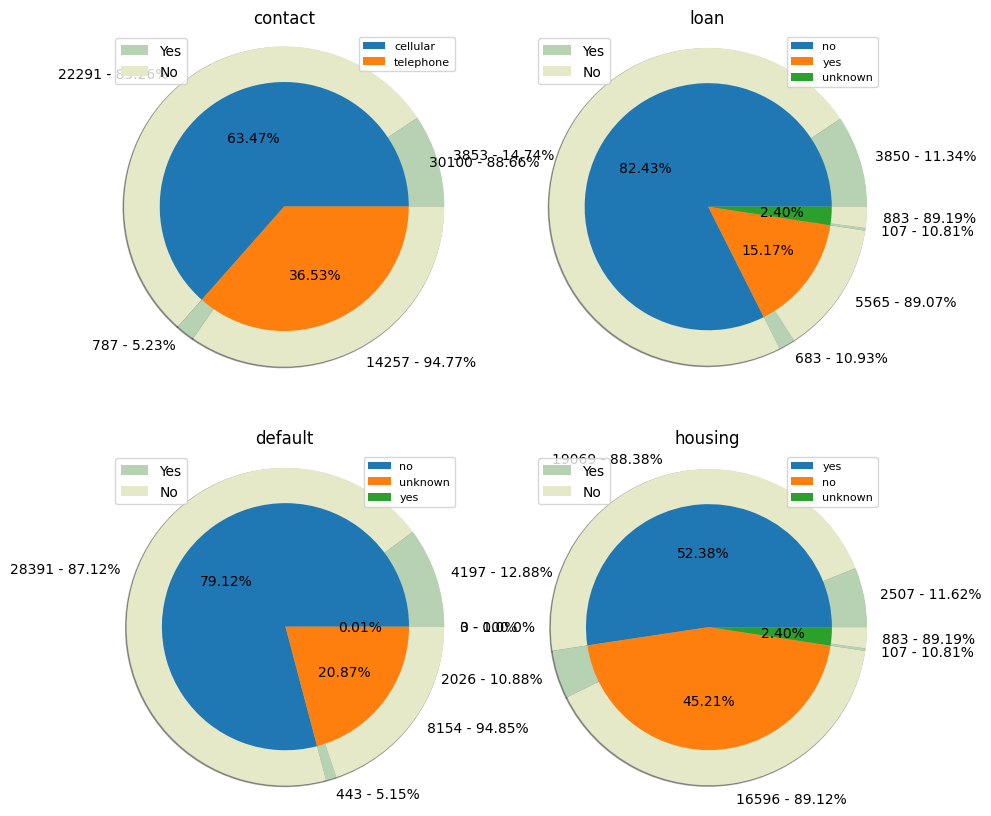

In [ ]:
make_plots_grid(data, ['contact', 'loan', 'default', 'housing'], 2, (10, 10), make_two_level_pie_chart)

`Default` has very small amount of values 'yes' and big part of it is 'unknown'.

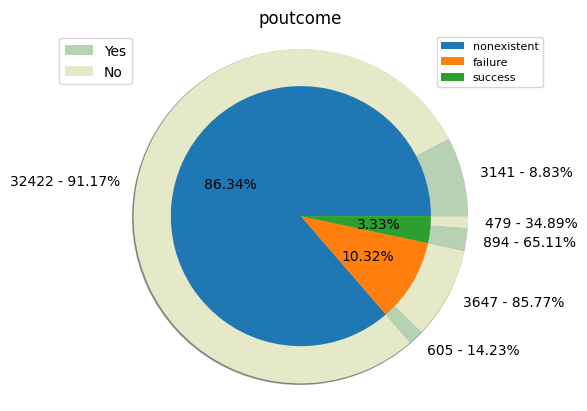

In [ ]:
make_two_level_pie_chart('poutcome', data, plt.subplot())

So, clients with `contact` is equal to 'cellular' have target feature 'yes' more often. About 15% of people with 'cellular' in `contact` subcribed a term deposit while among people with 'telephone' in `contact` this number is 5%.

Let's check if last contact month can affect the target feature.

In [ ]:
data.month.value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

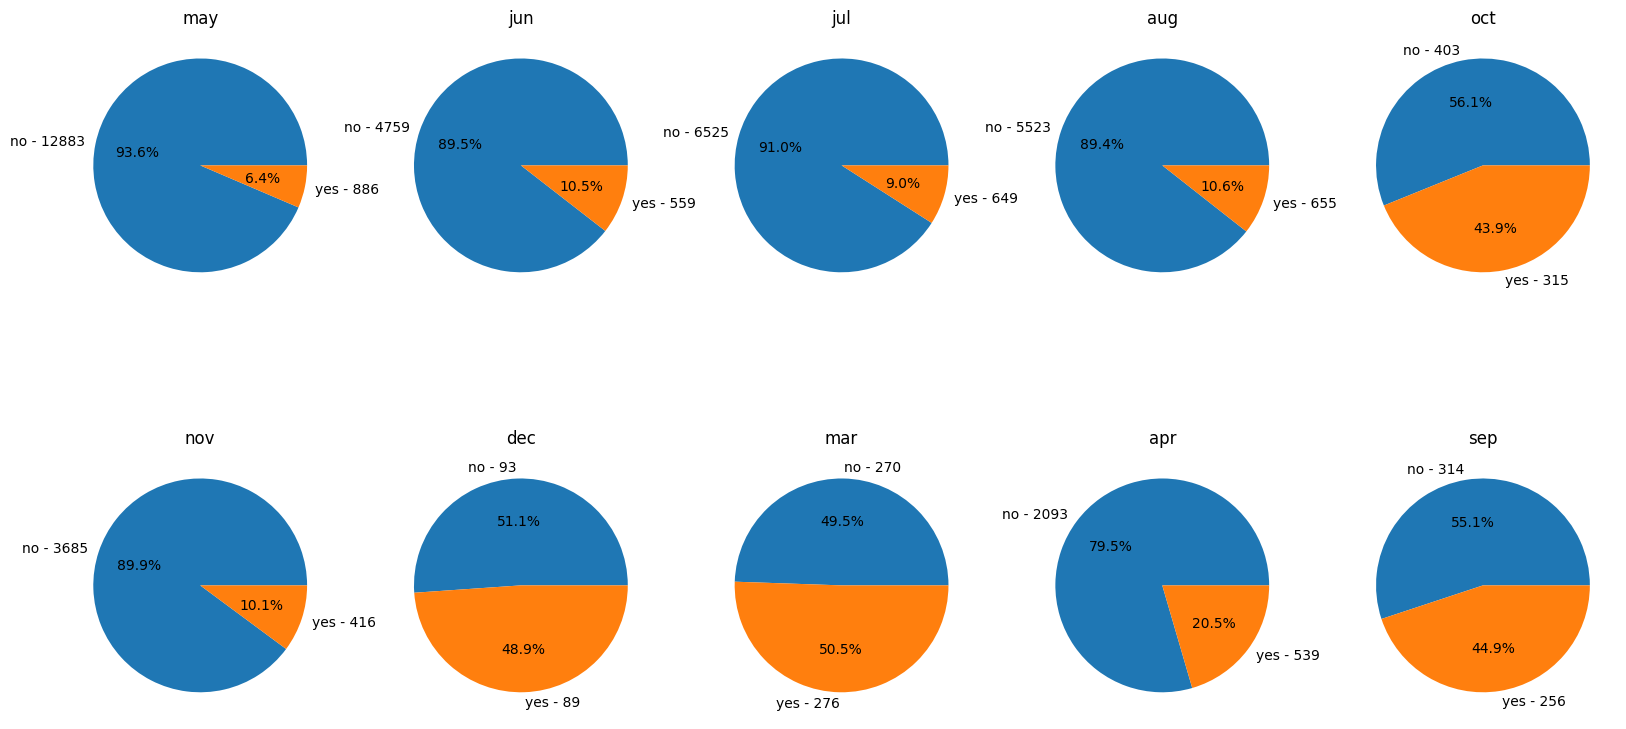

In [ ]:
def make_y_pie_grid(data, category, cols, figsize):
  categories = data[category].unique()
  size = len(categories)

  rows = math.ceil(size / cols)
  f, axis = plt.subplots(rows, cols, figsize=figsize)

  values = data[[category, 'y']].value_counts();

  for index in range(0, size):
    category_name = categories[index]
    ax = axis[int(index / cols), index % cols]

    subscribed_count = values[category_name, 'yes']
    refused_count = values[category_name, 'no']

    labels = ['no - ' + str(refused_count), 'yes - ' + str(subscribed_count)]
    ax.pie([refused_count, subscribed_count], labels=labels, autopct='%1.1f%%')
    ax.set_title(category_name)

make_y_pie_grid(data, 'month', 5, (20, 10))

So, people subscribed a term deposite more often in March, December, September and October and less often in May, for example. However, number of records with 'may' in `month` is much bigger than number of records with other mentioned values of this feature so it might be not representative.

We can see features in pairs using `sns.pairplot`

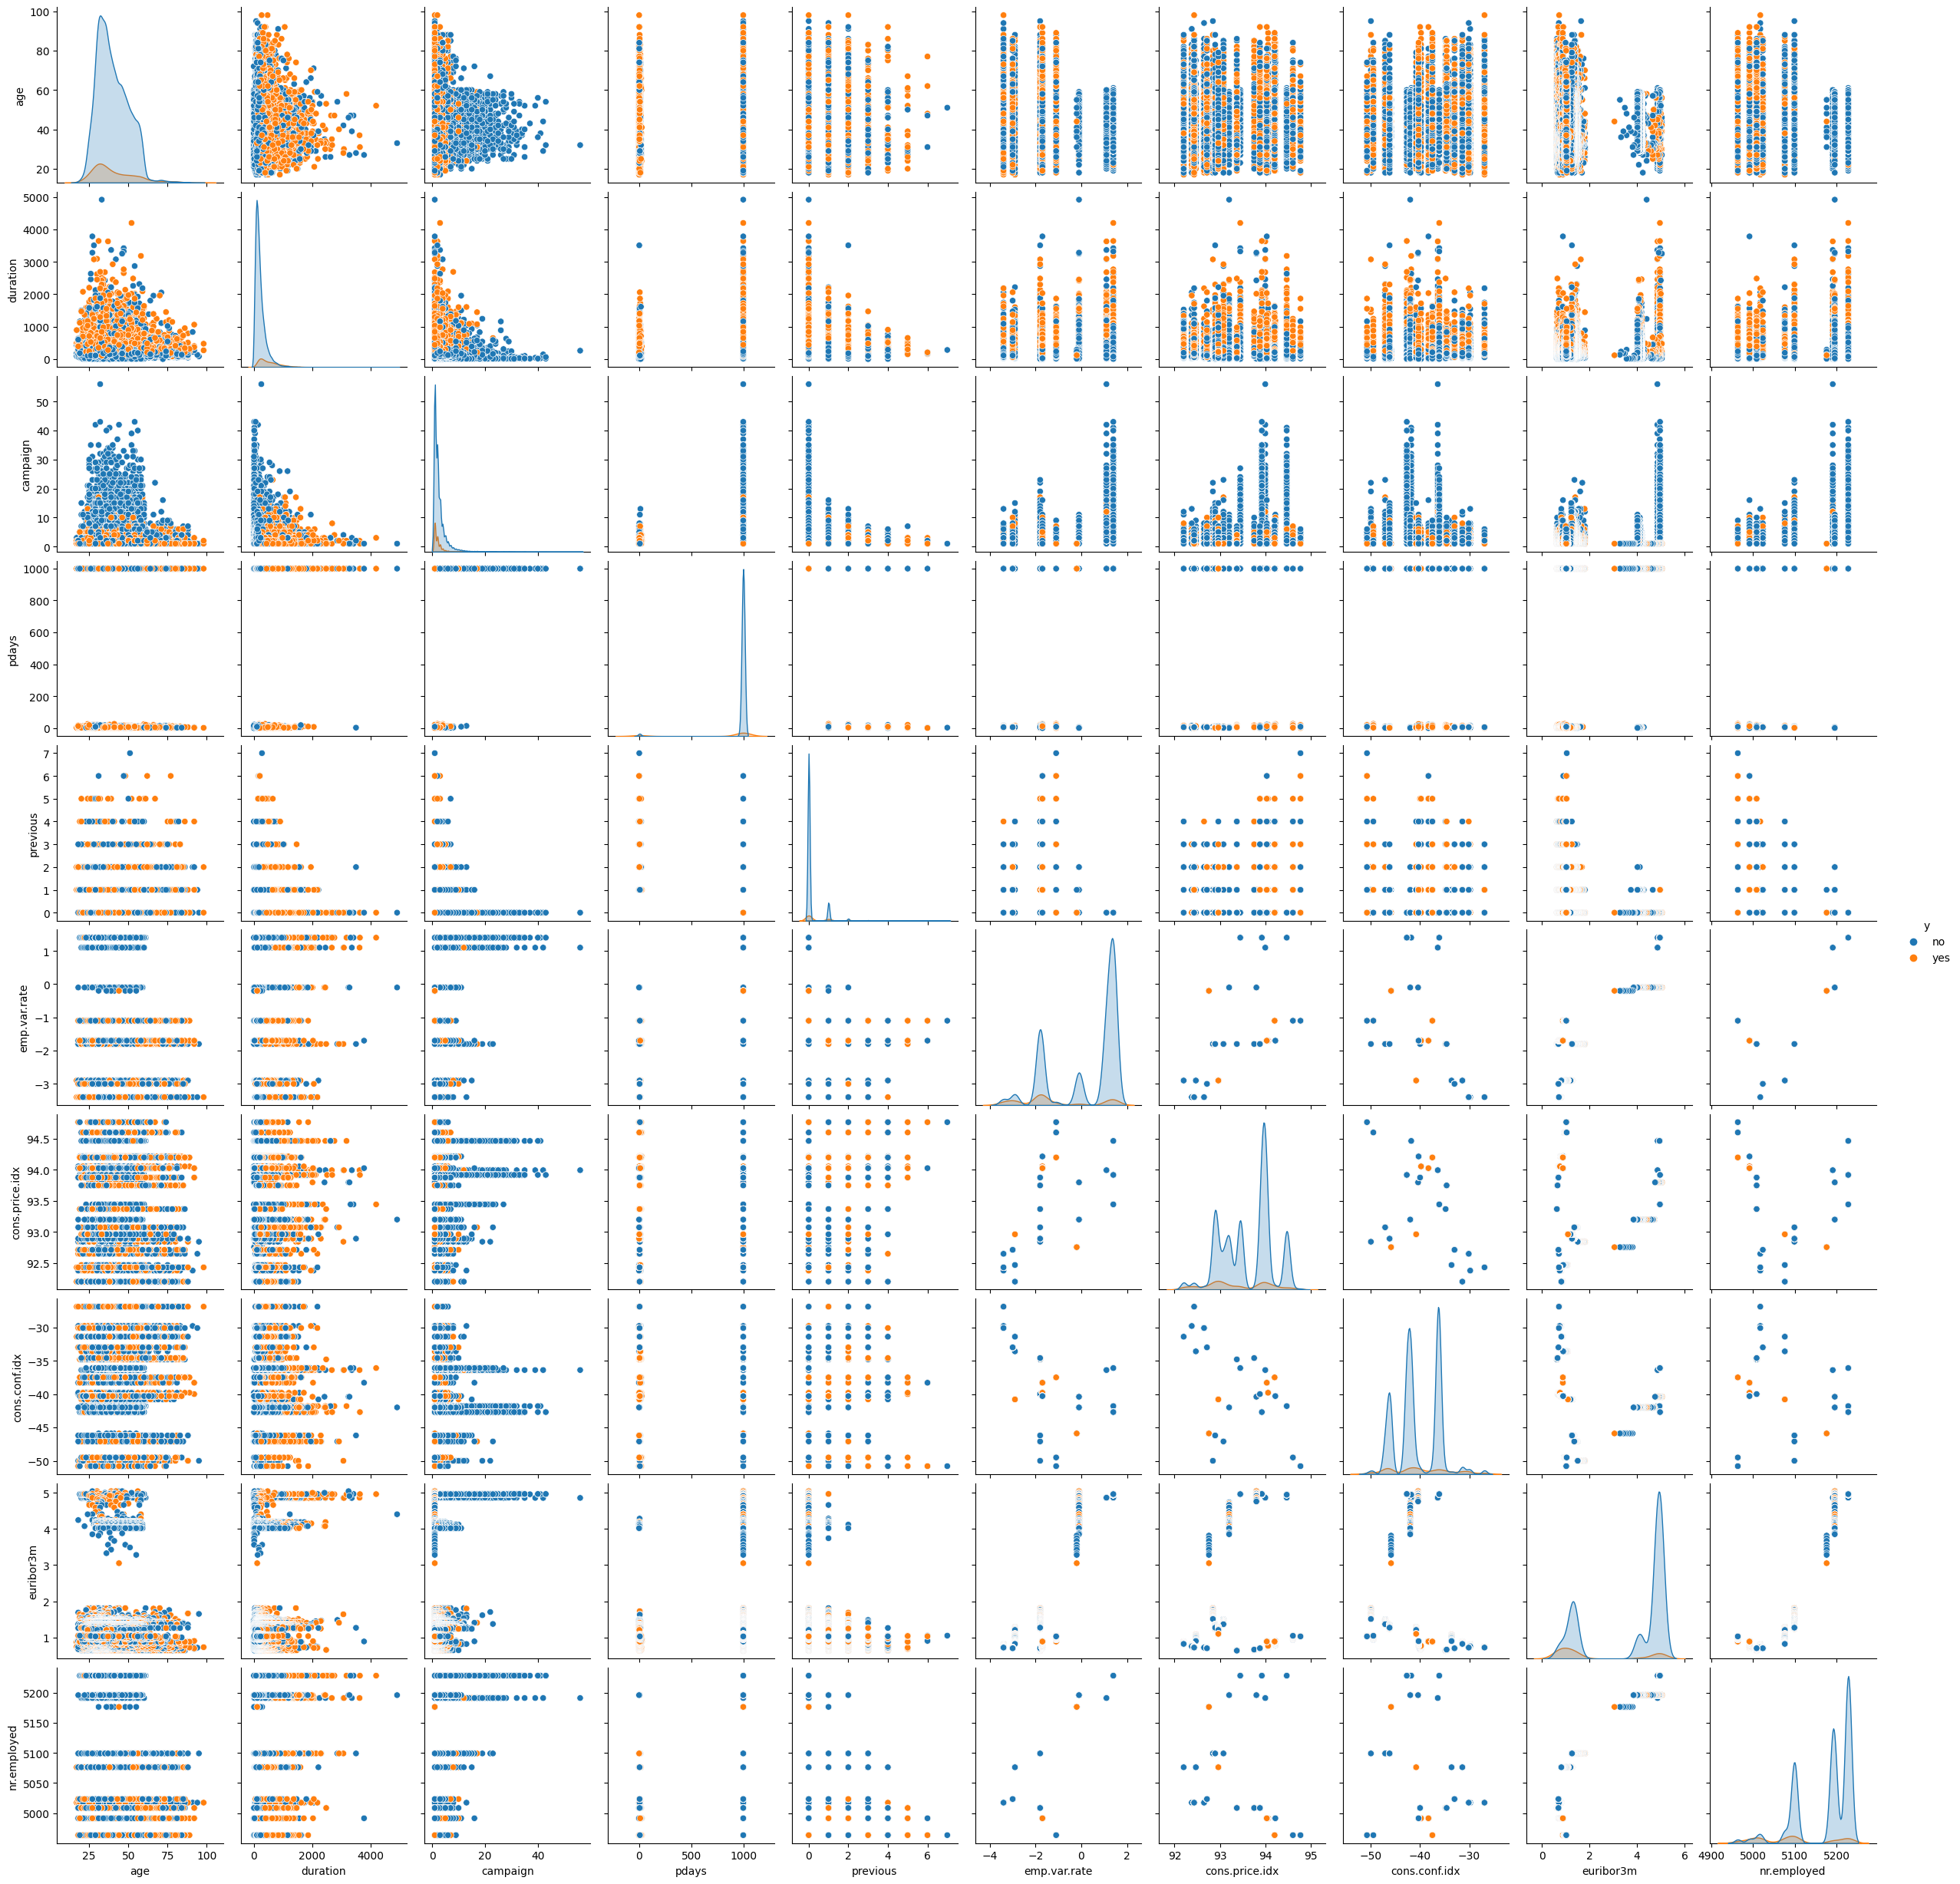

In [ ]:
sns.pairplot(data, hue='y')

As for new features, we can try combine `housing` and `loan` into feature that represents whether the customer has a loan at all. Also, we can try combine `job`, `education` and `contact` to see if the correlation between these features and target feature changes when they are combined.

In [ ]:
def is_yes(df, column):
    return (df[column] == "yes").astype(int)

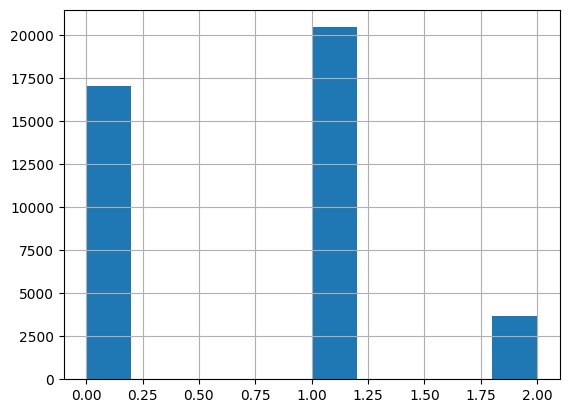

In [ ]:
has_loan = is_yes(data, "housing") + is_yes(data, "loan")
has_loan.hist()
has_loan = (has_loan == 1).astype(int)

We should make label encoding for target `y` in order to check the correlation.

In [ ]:
data["y"] = is_yes(data, "y")

In [ ]:
is_yes(data, "housing").corr(data["y"])

0.01174293836714359

In [ ]:
is_yes(data, "loan").corr(data["y"])

-0.004466117440488427

In [ ]:
has_loan.corr(data["y"])

0.010616376999294477

It seems that combining features `housing` and `loan` doesn't give any useful information.

#Part 2: DP

Our dasaset doesn't have null values but some fields are 'unknown'.

In [ ]:
unknowns = (data == 'unknown').sum()
unknowns = unknowns[unknowns > 0].sort_values(ascending=False)
unknowns

default      8597
education    1731
housing       990
loan          990
job           330
marital        80
dtype: int64

We can replace 'unknown' values in `education`, `marital` and `job` with most frequent values.

In [ ]:
imputer_freq = SimpleImputer(missing_values='unknown', strategy='most_frequent', verbose=True)
data[['education']] = imputer_freq.fit_transform(data[['education']])
data[['marital']] = imputer_freq.fit_transform(data[['marital']])
data[['job']] = imputer_freq.fit_transform(data[['job']])
imputed_freq_data = pd.DataFrame(data, columns=categorical_features)

I'd like to use label encoding for `job` (according to expected salary), `education` (combine basic and high school, course and university), `poutcome` and `contact`.

In [ ]:
dict_job = {
    "job":{
        "housemaid":1,
        "unemployed":0.5,
        "entrepreneur":4,
        "blue-collar":1,
        "services":3,
        "admin.":2,
        "technician":2,
        "retired":1,
        "management":4,
        "self-employed":3,
        "student":0.5
    }}

dict_education = {
    "education":{
        "basic.4y":1,
        "basic.6y":1,
        "basic.9y":1,
        "high.school":1,
        "professional.course":2,
        "university.degree":2,
        "illiterate":0.5,
    }}

dict_poutcome = {
    "poutcome":{
        "nonexistent":0,
        "failure":0,
        "success":1
    }}

dict_contact = {
    "contact":{
        "telephone": 0,
        "cellular": 1
    }}

In [ ]:
for i in [dict_poutcome, dict_education, dict_contact, dict_job]:
    data.replace(i,inplace=True)

For `marital`,`default`,`housing`, `loan`, `month` and `day_of_week` I'd like to use One-Hot encoding.

In [ ]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['marital', 'default','housing','loan', 'month', 'day_of_week']),
    remainder='passthrough')

transformed = transformer.fit_transform(data)
data = pd.DataFrame(transformed, columns=transformer.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for col in data:
  data[col] = data[col].astype(float)

In [ ]:
corr = data.corr()

In [ ]:
corr['y'].sort_values(axis=0, ascending=True)

nr.employed                  -0.354678
pdays                        -0.324914
euribor3m                    -0.307771
emp.var.rate                 -0.298334
cons.price.idx               -0.136211
onehotencoder__x4_may        -0.108271
onehotencoder__x1_unknown    -0.099293
campaign                     -0.066357
onehotencoder__x0_married    -0.042966
onehotencoder__x4_jul        -0.032230
job                          -0.027530
onehotencoder__x5_mon        -0.021265
onehotencoder__x4_nov        -0.011796
onehotencoder__x2_no         -0.011085
onehotencoder__x0_divorced   -0.010608
onehotencoder__x4_jun        -0.009182
onehotencoder__x4_aug        -0.008813
onehotencoder__x5_fri        -0.006996
onehotencoder__x3_yes        -0.004466
onehotencoder__x1_yes        -0.003041
onehotencoder__x3_unknown    -0.002270
onehotencoder__x2_unknown    -0.002270
onehotencoder__x3_no          0.005123
onehotencoder__x5_wed         0.006302
onehotencoder__x5_tue         0.008046
onehotencoder__x2_yes    

Let's draw the hitmap.

/tmp/ipykernel_5042/3571650133.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


Text(0.5, 1.0, 'Correlation')

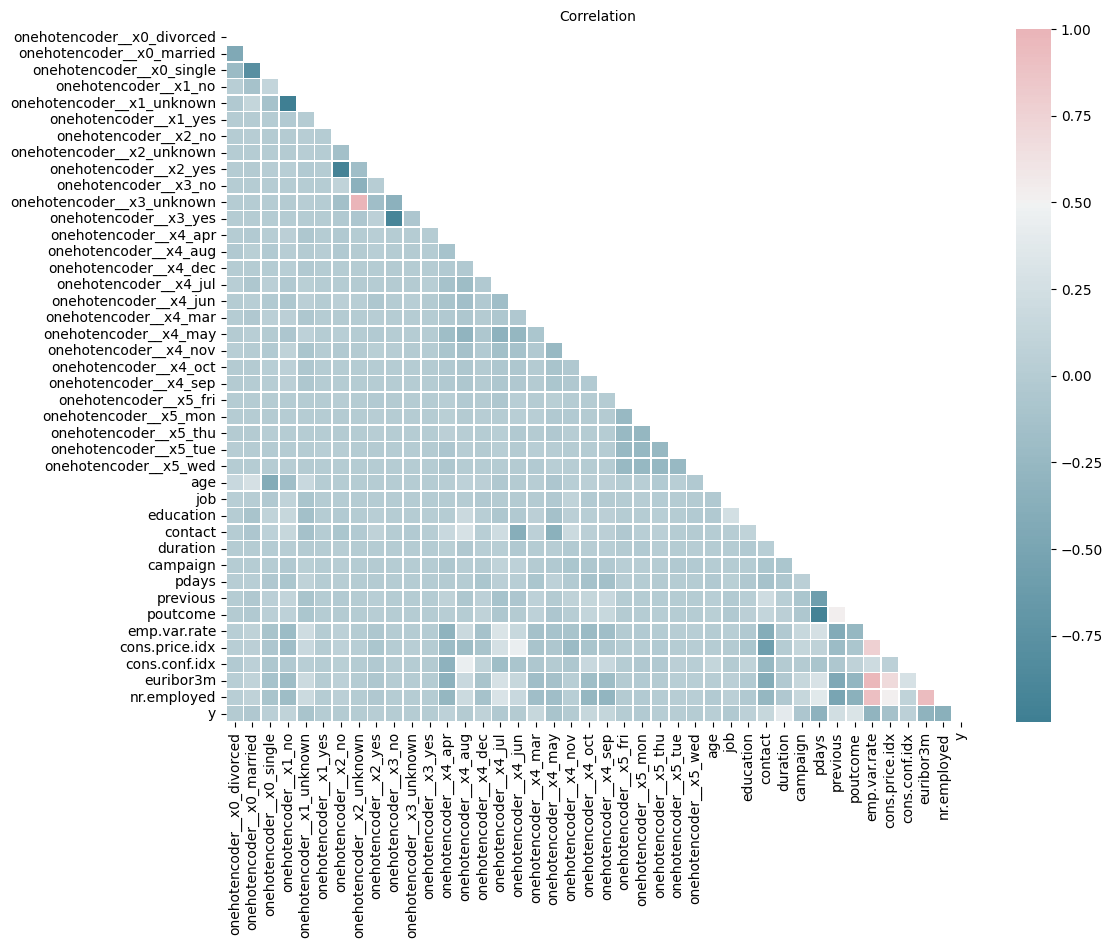

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0.5,
            linewidths=.5,
           )
plt.title("Correlation", fontsize =10)

We can see that features `duration`, `poutcome`, `contact` and `previous` have positive correlation with the target `y`.
Obviously `duration` affects the target because, e.g. if `duration`=0, we know that `y` is also 0.
Correlation with `poutcome` (outcome of the previous marketing campaign) means that clients with succesfull previous campaign are more likely to subscribe a term deposite. However, most clients don't have previous campaign, so we cannot make clear conclusion about the entire dataset.
Correlation with `contact` confirms our assumption: clients with 'cellular' in `contact` more often subscribe a deposit.
`previous` feature can affect the target in similar way to `poutcome`.

#Part 3: DR

We should scale our data.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

numeric_features = data.select_dtypes('number').columns

num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

pipe = ColumnTransformer(transformers=[
    ('num', num_pipe, numeric_features)
])

In [ ]:
X = pipe.fit_transform(data)

In [ ]:
X.shape

(41188, 42)

###PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


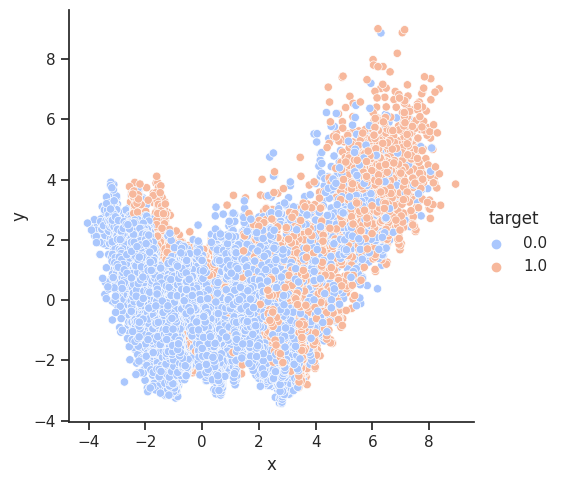

In [ ]:
plot_df = pd.DataFrame.from_records(data=pca_X[:,:2],columns=["x","y"])
y = ['y']
plot_df["target"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [ ]:
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = numeric_features

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

pd.DataFrame(dic.items())

,0,1
0,PC0,euribor3m
1,PC1,onehotencoder__x1_no


So, onehotencoder__x1_no (represents if client doesn't have credit in default) can affect the target variable.

In [ ]:
pca.explained_variance_ratio_.sum()

0.17768521016273436

In [ ]:
pca = PCA(n_components=0.95).fit(X)

len(pca.explained_variance_ratio_)

27

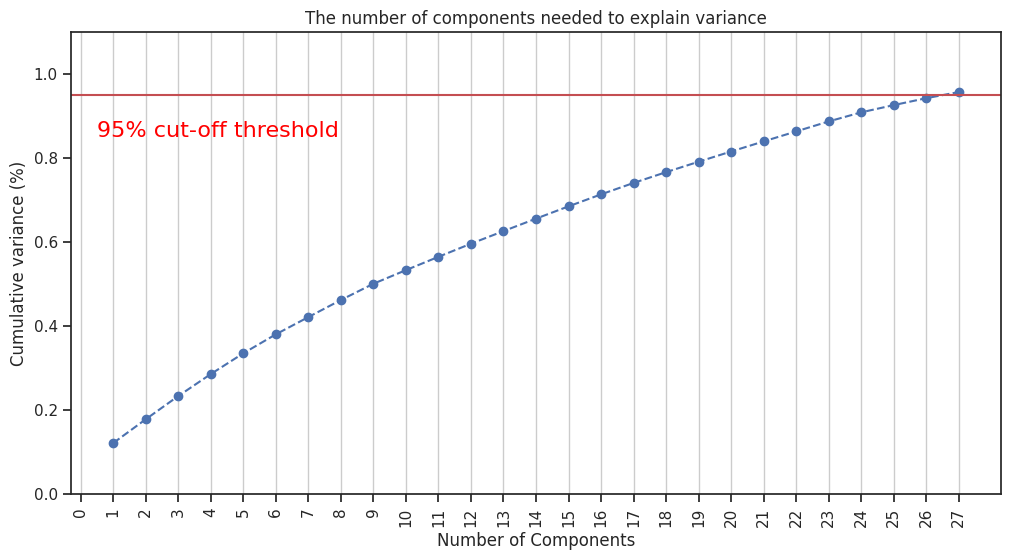

In [ ]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

###TSNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne_X = tsne.fit_transform(data[numeric_features])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


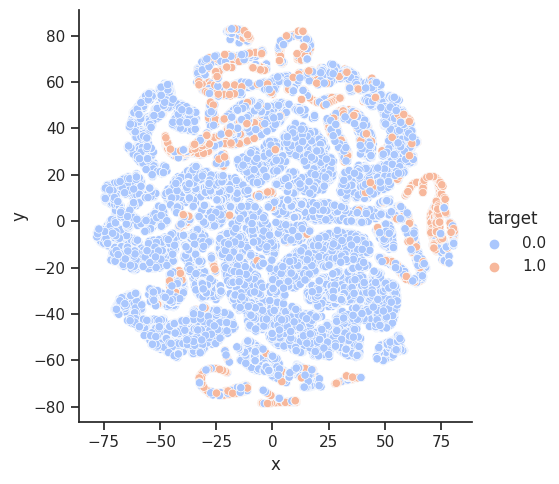

In [ ]:
plot_df = pd.DataFrame.from_records(data=tsne_X,columns=["x","y"])
y = ['y']
plot_df["target"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

###UMAP

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import umap.umap_ as umap

umap = umap.UMAP()

In [ ]:
umap_X = umap.fit_transform(data)
umap_X.shape

(41188, 2)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


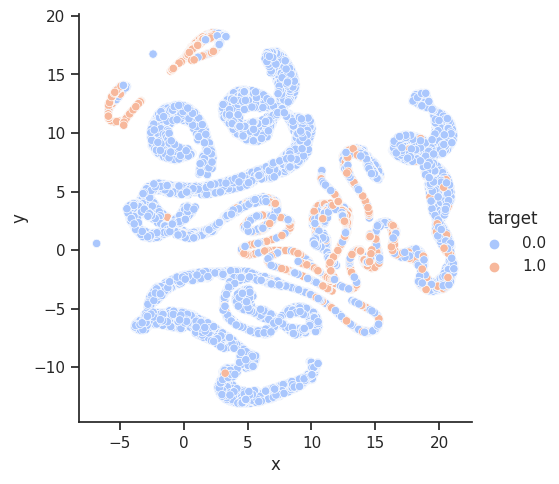

In [ ]:
plot_df = pd.DataFrame.from_records(data=umap_X,columns=["x","y"])
y = ['y']
plot_df["target"] = data[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')